# BERT System on PUBHEALTH dataset
Below I will be going over investigating two BERT models on verifying the veracity of PUBHEALTH data. The first model being scibert and the second being bert based . Both of which can be found on the huggingface website


**Loading libraries and dataset**

In [40]:
# !pip install datasets
# !pip install tensorflow
# !pip install transformers


In [91]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from tqdm.auto import tqdm
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

In [92]:
# Download PUBHEALTH dataset
dataset = load_dataset("health_fact")
print(dataset)

100%|██████████| 3/3 [00:00<00:00, 428.44it/s]

DatasetDict({
    train: Dataset({
        features: ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects'],
        num_rows: 9832
    })
    test: Dataset({
        features: ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects'],
        num_rows: 1235
    })
    validation: Dataset({
        features: ['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects'],
        num_rows: 1225
    })
})


**Evaluating dataset**

In [93]:
df_train = pd.DataFrame.from_dict(dataset["train"])
df_test = pd.DataFrame.from_dict(dataset["test"])
df_val = pd.DataFrame.from_dict(dataset["validation"])
df_train.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,


The explanation and claim are the main parts we will be looking make label classification
In the dataset, there appears to be a 3 and a -1. Unsure which label corresponds to "unproven", I took the example from the https://arxiv.org/pdf/2010.09926.pdf paper *"Blue Buffalo pet food contains unsafe and higher-than-average levels of lead"*

The paper states this is an "unproven" label and so removed all rows with -1

In [94]:
# 0 - false
# 1 - mixture
# 2 - true
print(df_train['label'].value_counts())

 2    5078
 0    3001
 1    1434
 3     291
-1      28
Name: label, dtype: int64


In [95]:
val = df_val[df_val['label']==3]
contain_values = val[val['claim'].str.contains('Blue Buffalo')]

print (contain_values)

    claim_id                                              claim  \
243    34307  Blue Buffalo pet food contains unsafe and high...   

     date_published                                        explanation  \
243  March 19, 2018  Aside from a single claimant’s lawsuit against...   

    fact_checkers                                          main_text sources  \
243  Kim LaCapria  In June 2017, a rumor appeared that Blue Buffa...           

     label                                subjects  
243      3  Critter Country, contaminated pet food  


In [96]:
# Removing -1 since unclear what it is supposed to represent
df_train = df_train[df_train['label']!=-1]
df_test = df_test[df_test['label']!=-1]
df_val = df_val[df_val['label']!=-1]


It would be ideal to use Sentence Transformer introduced (Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks, https://arxiv.org/pdf/1908.10084.pdf) in order to tackle the similarity aspect. 

It will help us understand whether the explanation is related to the claim. And in so "back up" the idea that label is true, false, mixture, unproven

However due to hardware and time restraint, chose to merge both claim and explanation and proceed with BERT embedding and classification. E.g. encoding explanation column took 25 minutes


In [97]:
#Simple approach of merging both claim and explanation
df_train['claim_explanation'] = df_train['claim'].map(str) + ' ' + df_train['explanation'].map(str)
df_test['claim_explanation'] = df_test['claim'].map(str) + ' ' + df_test['explanation'].map(str)
df_val['claim_explanation'] = df_val['claim'].map(str) + ' ' + df_val['explanation'].map(str)


# Since it is veracity of CLAIMS, remove columns except claim, label and explanation
df_train = df_train[['claim_explanation', 'label']]
df_test = df_test[['claim_explanation', 'label']]
df_val = df_val[['claim_explanation', 'label']]

df_train.head()

,claim_explanation,label
0,"""The money the Clinton Foundation took from fr...",0
1,Annual Mammograms May Have More False-Positive...,1
2,SBRT Offers Prostate Cancer Patients High Canc...,1
3,"Study: Vaccine for Breast, Ovarian Cancer Has ...",2
4,Some appendicitis cases may not require ’emerg...,2


**Loading tokenizer for encoding**

In [98]:
# tokenizer for encoding
from transformers import TFAutoModel, AutoTokenizer, AutoConfig
import torch

# Used scibert instead of base bert because it is trained on scientific text
model_name = "allenai/scibert_scivocab_uncased" 


# from_pt=true to work with tensorflow
sci_tokenizer = AutoTokenizer.from_pretrained(model_name,from_pt=True, do_lower_case=True)

In [101]:
# Tokenise
# recommennded sequence length 256 for 16 batch size (juipyter notebook memory issue force us to use 16)
SEQ_LEN = 256

train_id = np.zeros((len(df_train), SEQ_LEN))
train_masks = np.zeros((len(df_train), SEQ_LEN))

val_id = np.zeros((len(df_val), SEQ_LEN))
val_masks = np.zeros((len(df_val), SEQ_LEN))

test_id = np.zeros((len(df_test), SEQ_LEN))
test_masks = np.zeros((len(df_test), SEQ_LEN))



In [102]:
#create input ids and attention masks
def tokens_and_mask(df, ids, masks, tokenizer):
    for i, explanation in enumerate(df['claim_explanation']):
        tokenized_text = tokenizer.encode_plus(
            explanation,
            max_length=SEQ_LEN,
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True, # CLS, PAD, SEP
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text['input_ids']
        masks[i, :] = tokenized_text['attention_mask']
    return ids, masks

Create token ids and masks

In [103]:
X_train_input_ids, X_train_masks = tokens_and_mask(df_train, train_id, train_masks, sci_tokenizer)
X_val_input_ids, X_val_masks = tokens_and_mask(df_val, val_id, val_masks, sci_tokenizer)


In [104]:
# one-hot encode target vector
labels = np.zeros((len(df_train), 4))
labels[np.arange(len(df_train)), df_train['label'].values] = 1

labels_val = np.zeros((len(df_val), 4))
labels_val[np.arange(len(df_val)), df_val['label'].values] = 1


In [105]:
# create dataset with seperate element for each row of input
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_input_ids, X_train_masks, labels))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_input_ids, X_val_masks, labels_val))


In [106]:
# converting to required format for tensorflow dataset (have keys)
def mapping(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels
    
dataset_train = dataset_train.map(mapping) 
dataset_val = dataset_val.map(mapping) 

In [107]:
# shuffle data and make batch, drop any left
BATCH_SIZE = 16
# # https://stackoverflow.com/questions/57948003/ - change max_buffer_size to higher value
# BATCH_SIZE = 32


dataset_train = dataset_train.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)
dataset_val = dataset_val.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)

In [108]:
data_train = dataset_train.take(len(df_train))
data_val = dataset_val.take(len(df_val))

In [109]:
# Save some memory by deleting
del dataset_train
del dataset_val

**Loading Pretrained Model and building network**

In [110]:
config = AutoConfig.from_pretrained(model_name)
sci_model = TFAutoModel.from_config(config)

In [111]:
#Create network

# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

#Setup layers with relevant activation functions
# 3D tensor pooled into 2D tensor
bert_embds = sci_model.bert(input_ids, attention_mask=attn_masks)[1]
hidden_layer = tf.keras.layers.Dense(512, activation='relu', name='hidden_layer')(bert_embds)

# #dropout regularisation
# drop_out = tf.keras.layers.Dropout(0.8)(hidden_layer)

# softmax -> calcs probs of classes
# 4 because 4 classes
output_layer = tf.keras.layers.Dense(4, activation='softmax', name='output_layer')(hidden_layer)


In [112]:
veracity_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
veracity_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109918464   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
hidden_layer (Dense)            (None, 512)          393728      bert[0][1]                 

In [113]:
# define loss function, metrics and optimizer
veracity_model.compile(
    #use HP 2e-5  preferred in https://arxiv.org/pdf/1905.05583.pdf but use 10 epochs instead of 4
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, decay=1e-6),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics= tf.keras.metrics.CategoricalAccuracy('accuracy'))

In [114]:
# GPU check
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.version.VERSION)
print(tf.device('GPU'))

Num GPUs Available:  1
2.5.0


**Train Model**

In [115]:
with tf.device('GPU'):
    hist = veracity_model.fit(
        data_train,
        validation_data=data_val,
        epochs=7
    )

Epoch 1/7
612/612 [==============================] - 209s 327ms/step - loss: 0.9812 - accuracy: 0.5694 - val_loss: 0.8370 - val_accuracy: 0.6575
Epoch 2/7
612/612 [==============================] - 200s 326ms/step - loss: 0.8342 - accuracy: 0.6233 - val_loss: 0.7983 - val_accuracy: 0.6692
Epoch 3/7
612/612 [==============================] - 200s 326ms/step - loss: 0.7645 - accuracy: 0.6574 - val_loss: 0.7736 - val_accuracy: 0.6800
Epoch 4/7
612/612 [==============================] - 200s 327ms/step - loss: 0.6847 - accuracy: 0.7018 - val_loss: 0.9996 - val_accuracy: 0.6450
Epoch 5/7
612/612 [==============================] - 200s 327ms/step - loss: 0.5762 - accuracy: 0.7569 - val_loss: 0.8528 - val_accuracy: 0.6683
Epoch 6/7
612/612 [==============================] - 200s 327ms/step - loss: 0.4414 - accuracy: 0.8244 - val_loss: 0.9873 - val_accuracy: 0.6817
Epoch 7/7
612/612 [==============================] - 200s 327ms/step - loss: 0.2888 - accuracy: 0.8891 - val_loss: 1.3005 - val_ac

In [116]:
import csv
with open('sci_bert_test_no_dropout.csv', 'w') as f:
    w = csv.DictWriter(f, hist.history.keys())
    w.writeheader()
    w.writerow(hist.history)

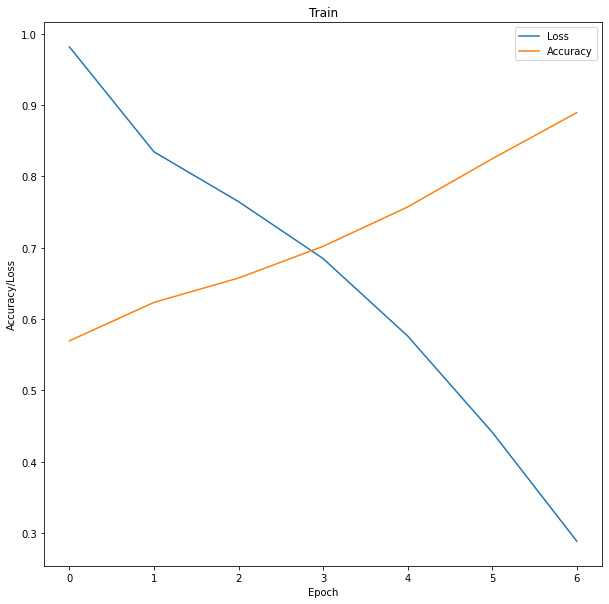

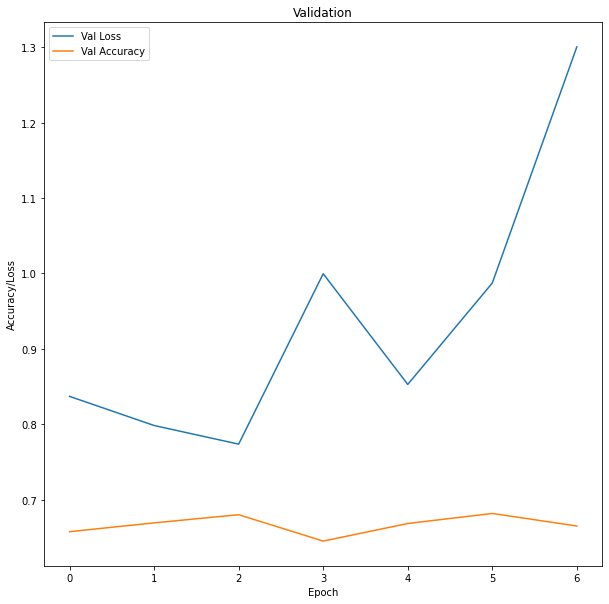

In [117]:
df = pd.read_csv("sci_bert_test_no_dropout.csv")

loss = eval(df["loss"][0])
accuracy = eval(df["accuracy"][0])
val_loss = eval(df["val_loss"][0])
val_accuracy = eval(df["val_accuracy"][0])

plt.figure(figsize=(10,10))
plt.title('Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.plot(np.arange(0, len(loss)),loss, label='Loss')
plt.plot(np.arange(0, len(accuracy)),accuracy, label='Accuracy')
plt.legend()

plt.figure(figsize=(10,10))
plt.title('Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.plot(np.arange(0, len(val_loss)),val_loss, label='Val Loss')
plt.plot(np.arange(0, len(val_accuracy)),val_accuracy, label='Val Accuracy')
plt.legend()

Interestingly, the validation graph shows no sign of progression over epochs. The loss keeps getting higher. Would be interesting to see over a lot more epochs if this is the case still.

In [118]:
veracity_model.save('sci_bert_test_no_dropout')

INFO:tensorflow:Assets written to: sci_bert_test_no_dropout\assets


INFO:tensorflow:Assets written to: sci_bert_test_no_dropout\assets


**Evaluate with Test Data**

In [119]:
loaded_model = tf.keras.models.load_model('sci_bert_test_no_dropout')

Use test data to create classification report which will tell us precision, recall, f1

In [120]:
def prepare_datas(input_text, tokenizer):
    processed_data = []
    for text in input_text:
        token = tokenizer.encode_plus(
            text,
            max_length=SEQ_LEN, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        processed_data.append({
            'input_ids': tf.cast(token.input_ids, tf.float64),
            'attention_mask': tf.cast(token.attention_mask, tf.float64)
        })
    return processed_data

#0 false, 1, mixture, 2 ture, 3 unproven
def make_predictions(model, processed_datas, classes=[0,1,2,3]):
    y_preds = []
    for x in processed_datas:
        probs = model.predict(x)[0]
        y_preds.append(classes[np.argmax(probs)])
    return y_preds

In [121]:
processed_datas = prepare_datas(df_test["claim_explanation"], sci_tokenizer)
y_preds = make_predictions(loaded_model, processed_datas)
print(f"Predicted Sentiment: {y_preds}")

Predicted Sentiment: [0, 2, 0, 0, 3, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 2, 3, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 0, 0, 0, 3, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 2, 3, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 2, 2, 3, 1, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 3, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 3, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 3, 2, 2, 0, 0, 2, 3, 2, 1, 0, 0, 2, 2, 1, 0, 1, 0, 0, 0, 1, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 0, 0, 2, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 1, 0, 0, 2, 2, 2, 0, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 3, 

In [122]:
from sklearn.metrics import classification_report
print(classification_report(list(df_test['label']), y_preds))

              precision    recall  f1-score   support

           0       0.57      0.71      0.63       388
           1       0.46      0.21      0.29       201
           2       0.77      0.80      0.79       599
           3       0.30      0.27      0.28        45

    accuracy                           0.66      1233
   macro avg       0.53      0.50      0.50      1233
weighted avg       0.64      0.66      0.64      1233



Scibert did fairly well getting getting 0.66 in accuracy. Only under 4 points less than scibert model in https://arxiv.org/pdf/2010.09926.pdf
As expected the f1-score is not good for 1 and 3. Suspect due to the imbalanced dataset having an abundance of 0 and 2, not not so much 1 and 3

Perhaps base bert model may do better? Let's find out

In [123]:
from transformers import TFBertModel
base_model = TFBertModel.from_pretrained('bert-base-cased')
base_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", do_lower_case=True)

# Repeated lines from above to make embedding and model for base bert

X_train_input_ids, X_train_masks = tokens_and_mask(df_train, train_id, train_masks, base_tokenizer)
X_val_input_ids, X_val_masks = tokens_and_mask(df_val, val_id, val_masks, base_tokenizer)

labels = np.zeros((len(df_train), 4))
labels[np.arange(len(df_train)), df_train['label'].values] = 1

labels_val = np.zeros((len(df_val), 4))
labels_val[np.arange(len(df_val)), df_val['label'].values] = 1

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_input_ids, X_train_masks, labels))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_input_ids, X_val_masks, labels_val))

dataset_train = dataset_train.map(mapping) 
dataset_val = dataset_val.map(mapping) 

dataset_train = dataset_train.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)
dataset_val = dataset_val.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)

data_train = dataset_train.take(len(df_train))
data_val = dataset_val.take(len(df_val))

# Save some memory by deleting
del dataset_train
del dataset_val


#Create network

input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

bert_embds = base_model.bert(input_ids, attention_mask=attn_masks)[1]
hidden_layer = tf.keras.layers.Dense(512, activation='relu', name='hidden_layer')(bert_embds)

output_layer = tf.keras.layers.Dense(4, activation='softmax', name='output_layer')(hidden_layer)

base_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)

base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, decay=1e-6),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics= tf.keras.metrics.CategoricalAccuracy('accuracy'))
    
with tf.device('GPU'):
    hist = base_model.fit(
        data_train,
        validation_data=data_val,
        epochs=7
    )
import csv
with open('base_bert_test_no_dropout.csv', 'w') as f:
    w = csv.DictWriter(f, hist.history.keys())
    w.writeheader()
    w.writerow(hist.history)

veracity_model.save('base_bert_test_no_dropout')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/7
612/612 [==============================] - 207s 327ms/step - loss: 0.7879 - accuracy: 0.6607 - val_loss: 0.6450 - val_accuracy: 0.7317
Epoch 2/7
612/612 [==============================] - 200s 326ms/step - loss: 0.5661 - accuracy: 0.7694 - val_loss: 0.6802 - val_accuracy: 0.7125
Epoch 3/7
612/612 [==============================] - 200s 326ms/step - loss: 0.4129 - accuracy: 0.8328 - val_loss: 0.6353 - val_accuracy: 0.7500
Epoch 4/7
612/612 [==============================] - 200s 326ms/step - loss: 0.2609 - accuracy: 0.9000 - val_loss: 0.7886 - val_accuracy: 0.7367
Epoch 5/7
612/612 [==============================] - 200s 326ms/step - loss: 0.1615 - accuracy: 0.9406 - val_loss: 1.0964 - val_accuracy: 0.7342
Epoch 6/7
612/612 [==============================] - 200s 326ms/step - loss: 0.1157 - accuracy: 0.9587 - val_loss: 1.1104 - val_accuracy: 0.7508
Epoch 7/7
612/612 [==============================] - 200s 327ms/step - loss: 0.0795 - accuracy: 0.9705 - val_loss: 1.1843 - val_ac

INFO:tensorflow:Assets written to: base_bert_test_no_dropout\assets


INFO:tensorflow:Assets written to: base_bert_test_no_dropout\assets


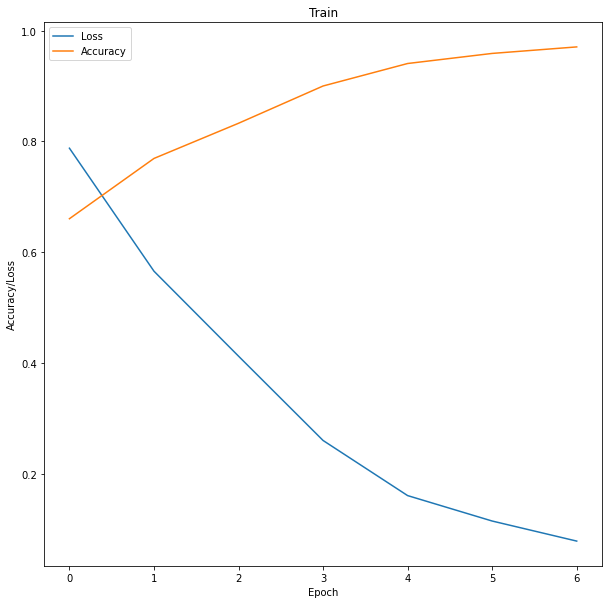

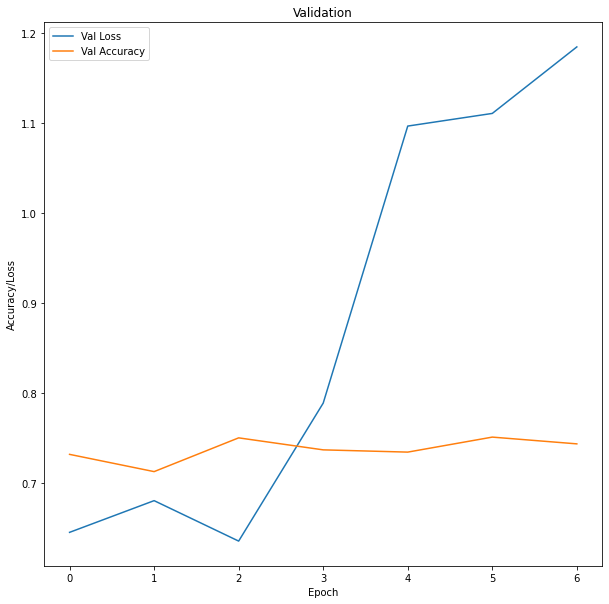

In [124]:
df = pd.read_csv("base_bert_test_no_dropout.csv")

loss = eval(df["loss"][0])
accuracy = eval(df["accuracy"][0])
val_loss = eval(df["val_loss"][0])
val_accuracy = eval(df["val_accuracy"][0])

plt.figure(figsize=(10,10))
plt.title('Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.plot(np.arange(0, len(loss)),loss, label='Loss')
plt.plot(np.arange(0, len(accuracy)),accuracy, label='Accuracy')
plt.legend()

plt.figure(figsize=(10,10))
plt.title('Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.plot(np.arange(0, len(val_loss)),val_loss, label='Val Loss')
plt.plot(np.arange(0, len(val_accuracy)),val_accuracy, label='Val Accuracy')
plt.legend()

Similarly validation shows no progression and validation loss rises (much quicker than train), train accuracy and loss however shows constant improvement over epochs

In [125]:
loaded_model = tf.keras.models.load_model('base_bert_test_no_dropout')

processed_datas = prepare_datas(df_test["claim_explanation"], base_tokenizer)
y_preds = make_predictions(loaded_model, processed_datas)


In [126]:
from sklearn.metrics import classification_report

print(classification_report(list(df_test['label']), y_preds))

              precision    recall  f1-score   support

           0       0.34      0.69      0.45       388
           1       0.10      0.00      0.01       201
           2       0.49      0.10      0.16       599
           3       0.04      0.31      0.08        45

    accuracy                           0.27      1233
   macro avg       0.24      0.27      0.17      1233
weighted avg       0.36      0.27      0.22      1233



Base bert is a more general model compared to Sci bert and that's perhaps the reason why the accuracy is much lower (0.27) compared to scibert's model. To conclude the first model we made is more ideal than the second.

**Key Notes**
- Overall the validation data has shown to not make much progress over epochs for both base bert and sci bert. Perhaps due to the way this has been approach. 
- Other things I could have done are including dropouts and schedulers.
- Employ sentence bert to encode contextualized representations for each of the evidence sentences and then rank these sentences according to their cosine similarity with respect to the contextualized representation of the claim sentence. Then select top ksentence for verracity prediction
- Limits due to memory issue e.g. sentence length and batch size "RESOURCE_EXHAUSTED: failed to allocate memory"
- Ideal model is the scibert model made first
